## Регрессия RUL (Deep Learning)

TO DO:
- параметры

DONE:
- LSTM

#### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from PIL import Image
import itertools
from time import time

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from tensorflow import GradientTape
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

C:\Users\I519322\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Чтение данных

In [2]:
df = pd.read_parquet('data/train_data.parquet')

In [3]:
test = pd.read_parquet('data/test_data.parquet')

In [4]:
df_feat = pd.read_parquet('data/train_data_feat.parquet')

In [5]:
test_feat = pd.read_parquet('data/test_data_feat.parquet')

In [6]:
feat_imp = pd.read_parquet('data/feature_imp_reg.parquet')

Отшкалируем данные и удалим наны

In [7]:
# params = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
#        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
#        's15', 's16', 's17', 's18', 's19', 's20', 's21']

params = ['setting1', 'setting2', 's2', 's3', 's4', 's7', 
          's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 
          's20', 's21']

# параметры отобранные случайным лесом
params_imp = feat_imp.feature[:100]

In [8]:
scaler = StandardScaler()
df[params] = scaler.fit_transform(df[params])

In [9]:
test[params] = scaler.fit_transform(test[params])

In [10]:
df_feat[params_imp] = scaler.fit_transform(df_feat[params_imp])

In [11]:
test_feat[params_imp] = scaler.fit_transform(test_feat[params_imp])

#### Нейронные сети

Генерация последовательностей с окном 50

In [12]:
def seq_generator(data, seq_len, seq_cols):
    
    dt = data[seq_cols].values
    num_elem = dt.shape[0]
    for start, stop in zip(range(0, num_elem-seq_len), range(seq_len, num_elem)):
        yield df[start:stop, :]
        
def gen_labels(data, seq_len, label):
    
    dt = data[seq_cols].values
    num_elem = dt.shape[0]
    return dt[seq_len:num_elem, :]


In [13]:
def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

In [14]:
xtrain, xtest = [], []

seq_len = 50

for eid in df.id.unique():
    for seq in gen_sequence(df[df.id==eid], seq_len, params):
        xtrain.append(seq)
    for seq in gen_sequence(test[test.id==eid], seq_len, params):
        xtest.append(seq)
        
xtrain = np.asarray(xtrain)
xtest = np.asarray(xtest)

print('Xtrain shape: {},\nXtest shape: {}'.format(xtrain.shape, xtest.shape))

Xtrain shape: (15631, 50, 16),
Xtest shape: (8162, 50, 16)


In [15]:
ytrain, ytest = [],[]

for eid in df.id.unique():
    for label in gen_labels(df[df.id==eid], seq_len, ['RUL']):
        ytrain.append(label)
    for label in gen_labels(test[test.id==eid], seq_len, ['RUL']):
        ytest.append(label)
        
ytrain = np.asarray(ytrain).reshape(-1,1)
ytest = np.asarray(ytest).reshape(-1,1)

print('Ytrain shape: {},\nYtest shape: {}'.format(ytrain.shape, ytest.shape))

Ytrain shape: (15631, 1),
Ytest shape: (8162, 1)


#### LSTM Рекуррентные нейронные сети

In [50]:
model = Sequential()
model.add(LSTM(
         units=100,
         input_shape = (seq_len, len(params)),
         return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="adam", metrics=['mse'])

In [51]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50, 100)           46800     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 127,301
Trainable params: 127,301
Non-trainable params: 0
________________________________________________

In [52]:
early_stopping =EarlyStopping(monitor='val_loss', patience=10)

hist = model.fit(xtrain, ytrain,
                 epochs=40, 
                 batch_size=200, 
                 validation_split=0.1, 
                 verbose=1,
                 callbacks=[early_stopping])

Train on 14067 samples, validate on 1564 samples
Epoch 1/40
14067/14067 [==============================] - 69s 5ms/sample - loss: 8172.3177 - mse: 8172.3184 - val_loss: 10174.4669 - val_mse: 10174.4668
Epoch 2/40
14067/14067 [==============================] - 54s 4ms/sample - loss: 6849.9788 - mse: 6849.9790 - val_loss: 9149.9117 - val_mse: 9149.9111
Epoch 3/40
14067/14067 [==============================] - 53s 4ms/sample - loss: 6076.2145 - mse: 6076.2144 - val_loss: 8286.8660 - val_mse: 8286.8652
Epoch 4/40
14067/14067 [==============================] - 55s 4ms/sample - loss: 5559.0336 - mse: 5559.0327 - val_loss: 7582.0759 - val_mse: 7582.0757
Epoch 5/40
14067/14067 [==============================] - 49s 4ms/sample - loss: 4836.8085 - mse: 4836.8086 - val_loss: 6823.3312 - val_mse: 6823.3311
Epoch 6/40
14067/14067 [==============================] - 49s 4ms/sample - loss: 4293.1247 - mse: 4293.1250 - val_loss: 6187.9456 - val_mse: 6187.9458
Epoch 7/40
14067/14067 [===================

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


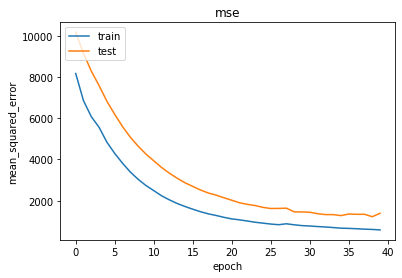

In [53]:
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('mse')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
scores = model.evaluate(xtrain, ytrain, verbose=0, batch_size=200)
print('Score: {}'.format(scores[1]))

Score: 593.3049926757812


In [55]:
scores = model.evaluate(xtest, ytest, verbose=0, batch_size=200)
print('Score: {}'.format(scores[1]))

Score: 2451.986572265625


In [56]:
pred = model.predict(xtest)

In [57]:
pd.DataFrame({'Metrics': ['RMSE', 'MAE', 'R2'],    
              'Linear': [np.sqrt(mean_squared_error(ytest, pred)),
                         mean_absolute_error(ytest, pred),
                         r2_score(ytest, pred)]
              })

,Metrics,Linear
0,RMSE,49.517536
1,MAE,38.447301
2,R2,0.096501


76/1 - 0s - loss: 1143.4529 - mse: 1252.6033
Test Score: 1252.60 MSE (35.39 RMSE)


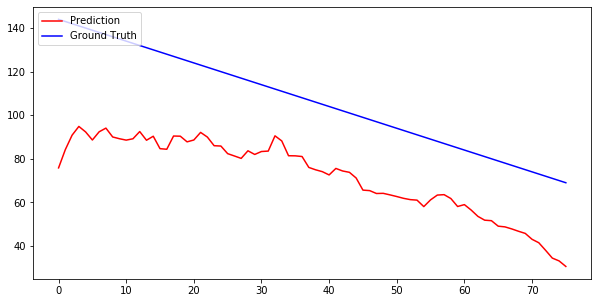

In [58]:
xtest_1, ytest_1 = [], []

for seq in gen_sequence(test[test.id==3], seq_len, params):
    xtest_1.append(seq)
for label in gen_labels(test[test.id==3], seq_len, ['RUL']):
    ytest_1.append(label)

xtest_1 = np.asarray(xtest_1)
ytest_1 = np.asarray(ytest_1).reshape(-1,1)

scores_test = model.evaluate(xtest_1,ytest_1, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (scores_test[0], math.sqrt(scores_test[0])))

pred = model.predict(xtest_1)

plt.figure(figsize=(10,5))
plt.plot(pred, color='red', label='Prediction')
plt.plot(ytest_1, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

48/1 - 0s - loss: 588.7701 - mse: 878.8499
Test Score: 878.85 MSE (29.65 RMSE)


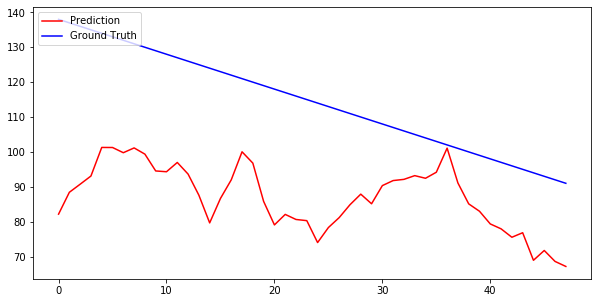

In [59]:
xtest_1, ytest_1 = [], []

for seq in gen_sequence(test[test.id==5], seq_len, params):
    xtest_1.append(seq)
for label in gen_labels(test[test.id==5], seq_len, ['RUL']):
    ytest_1.append(label)

xtest_1 = np.asarray(xtest_1)
ytest_1 = np.asarray(ytest_1).reshape(-1,1)

scores_test = model.evaluate(xtest_1,ytest_1, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (scores_test[0], math.sqrt(scores_test[0])))

pred = model.predict(xtest_1)

plt.figure(figsize=(10,5))
plt.plot(pred, color='red', label='Prediction')
plt.plot(ytest_1, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

55/1 - 0s - loss: 102.1791 - mse: 158.0323
Test Score: 158.03 MSE (12.57 RMSE)


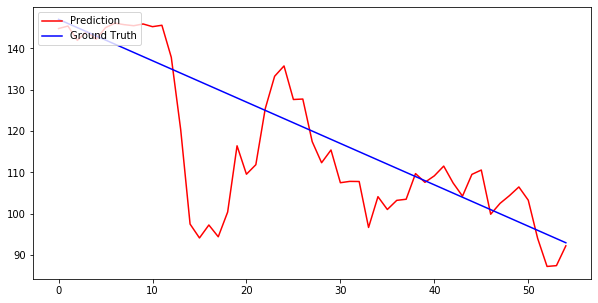

In [60]:
xtest_1, ytest_1 = [], []

for seq in gen_sequence(test[test.id==6], seq_len, params):
    xtest_1.append(seq)
for label in gen_labels(test[test.id==6], seq_len, ['RUL']):
    ytest_1.append(label)

xtest_1 = np.asarray(xtest_1)
ytest_1 = np.asarray(ytest_1).reshape(-1,1)

scores_test = model.evaluate(xtest_1,ytest_1, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (scores_test[0], math.sqrt(scores_test[0])))

pred = model.predict(xtest_1)

plt.figure(figsize=(10,5))
plt.plot(pred, color='red', label='Prediction')
plt.plot(ytest_1, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

110/1 - 0s - loss: 1144.8116 - mse: 1705.1212
Test Score: 1705.12 MSE (41.29 RMSE)


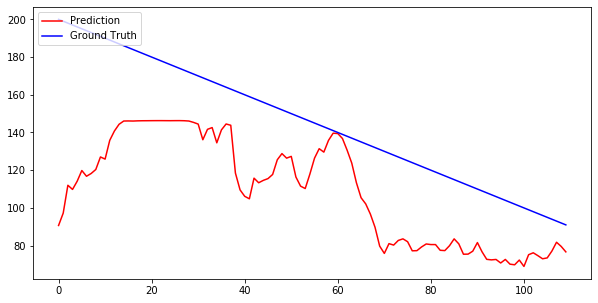

In [61]:
xtest_1, ytest_1 = [], []

for seq in gen_sequence(test[test.id==7], seq_len, params):
    xtest_1.append(seq)
for label in gen_labels(test[test.id==7], seq_len, ['RUL']):
    ytest_1.append(label)

xtest_1 = np.asarray(xtest_1)
ytest_1 = np.asarray(ytest_1).reshape(-1,1)

scores_test = model.evaluate(xtest_1,ytest_1, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (scores_test[0], math.sqrt(scores_test[0])))

pred = model.predict(xtest_1)

plt.figure(figsize=(10,5))
plt.plot(pred, color='red', label='Prediction')
plt.plot(ytest_1, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

116/1 - 0s - loss: 2121.0630 - mse: 3590.6875
Test Score: 3590.69 MSE (59.92 RMSE)


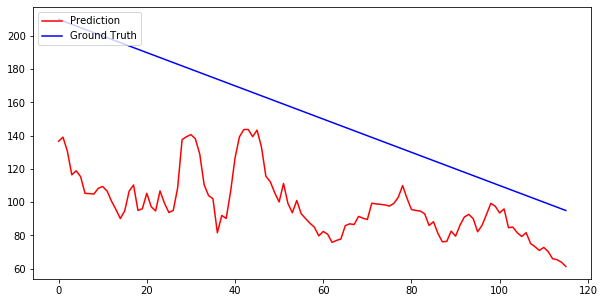

In [62]:
xtest_1, ytest_1 = [], []

for seq in gen_sequence(test[test.id==8], seq_len, params):
    xtest_1.append(seq)
for label in gen_labels(test[test.id==8], seq_len, ['RUL']):
    ytest_1.append(label)

xtest_1 = np.asarray(xtest_1)
ytest_1 = np.asarray(ytest_1).reshape(-1,1)

scores_test = model.evaluate(xtest_1,ytest_1, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (scores_test[0], math.sqrt(scores_test[0])))

pred = model.predict(xtest_1)

plt.figure(figsize=(10,5))
plt.plot(pred, color='red', label='Prediction')
plt.plot(ytest_1, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

142/1 - 0s - loss: 2799.9433 - mse: 4060.4424
Test Score: 4060.44 MSE (63.72 RMSE)


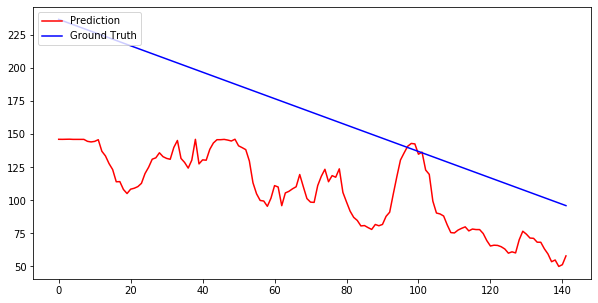

In [63]:
xtest_1, ytest_1 = [], []

for seq in gen_sequence(test[test.id==10], seq_len, params):
    xtest_1.append(seq)
for label in gen_labels(test[test.id==10], seq_len, ['RUL']):
    ytest_1.append(label)

xtest_1 = np.asarray(xtest_1)
ytest_1 = np.asarray(ytest_1).reshape(-1,1)

scores_test = model.evaluate(xtest_1,ytest_1, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (scores_test[0], math.sqrt(scores_test[0])))

pred = model.predict(xtest_1)

plt.figure(figsize=(10,5))
plt.plot(pred, color='red', label='Prediction')
plt.plot(ytest_1, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

134/1 - 0s - loss: 398.2318 - mse: 512.2426
Test Score: 512.24 MSE (22.63 RMSE)


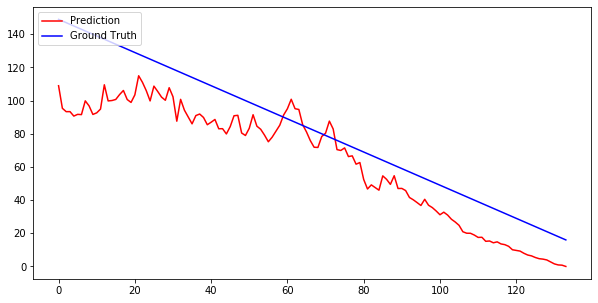

In [64]:
xtest_1, ytest_1 = [], []

for seq in gen_sequence(test[test.id==20], seq_len, params):
    xtest_1.append(seq)
for label in gen_labels(test[test.id==20], seq_len, ['RUL']):
    ytest_1.append(label)

xtest_1 = np.asarray(xtest_1)
ytest_1 = np.asarray(ytest_1).reshape(-1,1)

scores_test = model.evaluate(xtest_1,ytest_1, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (scores_test[0], math.sqrt(scores_test[0])))

pred = model.predict(xtest_1)

plt.figure(figsize=(10,5))
plt.plot(pred, color='red', label='Prediction')
plt.plot(ytest_1, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

148/1 - 0s - loss: 478.0010 - mse: 459.8793
Test Score: 459.88 MSE (21.44 RMSE)


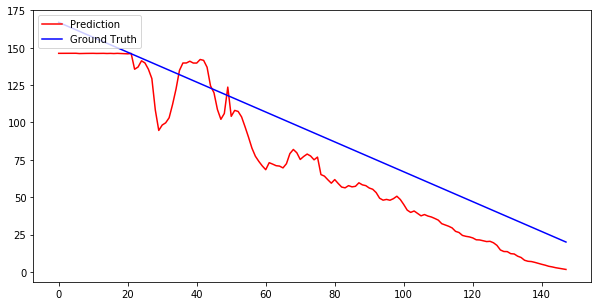

In [65]:
xtest_1, ytest_1 = [], []

for seq in gen_sequence(test[test.id==100], seq_len, params):
    xtest_1.append(seq)
for label in gen_labels(test[test.id==100], seq_len, ['RUL']):
    ytest_1.append(label)

xtest_1 = np.asarray(xtest_1)
ytest_1 = np.asarray(ytest_1).reshape(-1,1)

scores_test = model.evaluate(xtest_1,ytest_1, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (scores_test[0], math.sqrt(scores_test[0])))

pred = model.predict(xtest_1)

plt.figure(figsize=(10,5))
plt.plot(pred, color='red', label='Prediction')
plt.plot(ytest_1, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

126/1 - 0s - loss: 829.0900 - mse: 956.4988
Test Score: 956.50 MSE (30.93 RMSE)


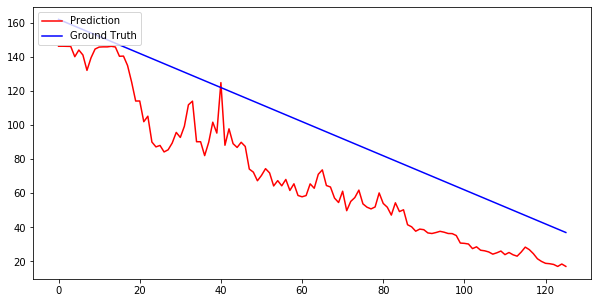

In [66]:
xtest_1, ytest_1 = [], []

for seq in gen_sequence(test[test.id==58], seq_len, params):
    xtest_1.append(seq)
for label in gen_labels(test[test.id==58], seq_len, ['RUL']):
    ytest_1.append(label)

xtest_1 = np.asarray(xtest_1)
ytest_1 = np.asarray(ytest_1).reshape(-1,1)

scores_test = model.evaluate(xtest_1,ytest_1, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (scores_test[0], math.sqrt(scores_test[0])))

pred = model.predict(xtest_1)

plt.figure(figsize=(10,5))
plt.plot(pred, color='red', label='Prediction')
plt.plot(ytest_1, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

In [67]:
seq_array_test_last = [test[test['id']==id][params].values[-seq_len:] 
                       for id in test['id'].unique() if len(test[test['id']==id]) >= seq_len]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 16)

In [68]:
y_mask = [len(test[test['id']==id]) >= seq_len for id in test['id'].unique()]

In [69]:
label_array_test_last = test.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [70]:
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (scores_test[0], math.sqrt(scores_test[0])))

93/1 - 2s - loss: 1016.5914 - mse: 966.5284
Test Score: 966.53 MSE (31.09 RMSE)


In [71]:
pred = model.predict(seq_array_test_last)
pred

array([[ 29.157433 ],
       [ 56.166973 ],
       [ 67.69819  ],
       [ 92.95976  ],
       [ 73.76899  ],
       [ 54.757298 ],
       [ 86.62552  ],
       [ 58.16954  ],
       [ 46.833714 ],
       [ 53.74147  ],
       [ 54.615704 ],
       [ 97.242386 ],
       [ 65.32845  ],
       [ 27.567032 ],
       [ 18.930939 ],
       [ 57.50326  ],
       [  0.       ],
       [ 37.54655  ],
       [ 95.16997  ],
       [  1.5032575],
       [ 87.83264  ],
       [ 53.698112 ],
       [ 68.35457  ],
       [ 61.830112 ],
       [ 51.30086  ],
       [  0.       ],
       [ 25.912619 ],
       [ 72.394745 ],
       [  0.       ],
       [  0.       ],
       [  0.       ],
       [ 12.889328 ],
       [ 29.91541  ],
       [  1.8825053],
       [  9.407745 ],
       [  0.       ],
       [ 30.753069 ],
       [111.13824  ],
       [ 54.402046 ],
       [ 15.946719 ],
       [ 72.67221  ],
       [115.505    ],
       [  0.       ],
       [ 63.402447 ],
       [ 70.018745 ],
       [  

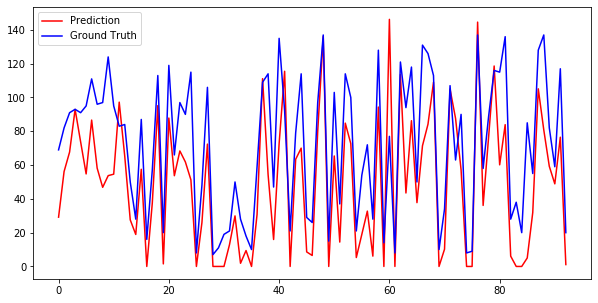

In [72]:
plt.figure(figsize=(10,5))
plt.plot(pred, color='red', label='Prediction')
plt.plot(label_array_test_last, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()